Attempting to load data from: c:\Users\Hongyu\OneDrive - Northwestern University\NU\MSDS 460 Decision Analytics\Discussion 8\baseball-simulation-project\prepared_data\
Found: c:\Users\Hongyu\OneDrive - Northwestern University\NU\MSDS 460 Decision Analytics\Discussion 8\baseball-simulation-project\prepared_data\cubs_standard_batting_clean.csv
Found: c:\Users\Hongyu\OneDrive - Northwestern University\NU\MSDS 460 Decision Analytics\Discussion 8\baseball-simulation-project\prepared_data\cubs_standard_pitching_clean.csv
Found: c:\Users\Hongyu\OneDrive - Northwestern University\NU\MSDS 460 Decision Analytics\Discussion 8\baseball-simulation-project\prepared_data\whitesox_standard_batting_clean.csv
Found: c:\Users\Hongyu\OneDrive - Northwestern University\NU\MSDS 460 Decision Analytics\Discussion 8\baseball-simulation-project\prepared_data\whitesox_standard_pitching_clean.csv
Running 10000 simulations...
Completed 500/10000 simulations...
Completed 1000/10000 simulations...
Completed 1500/100

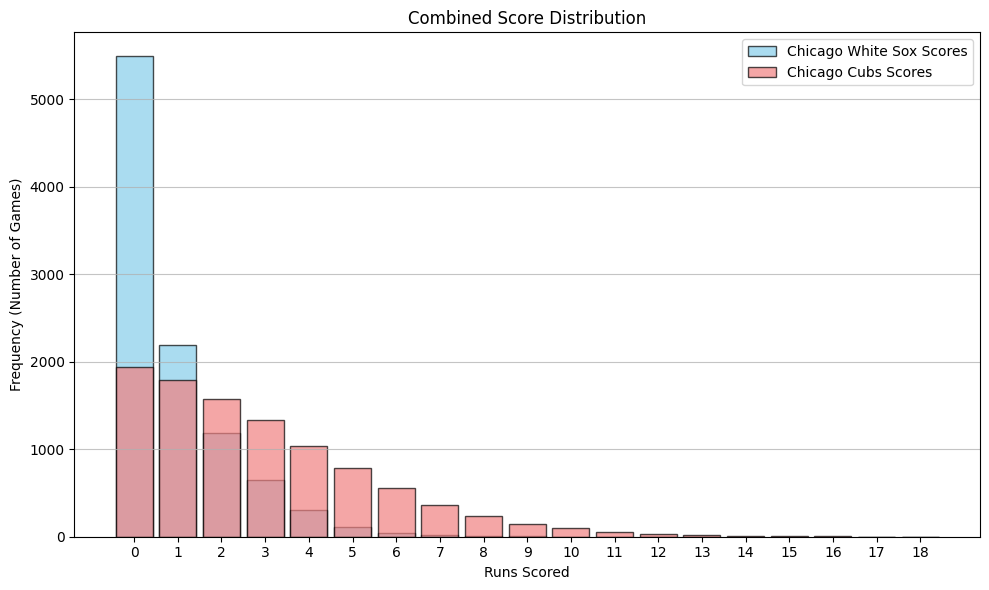

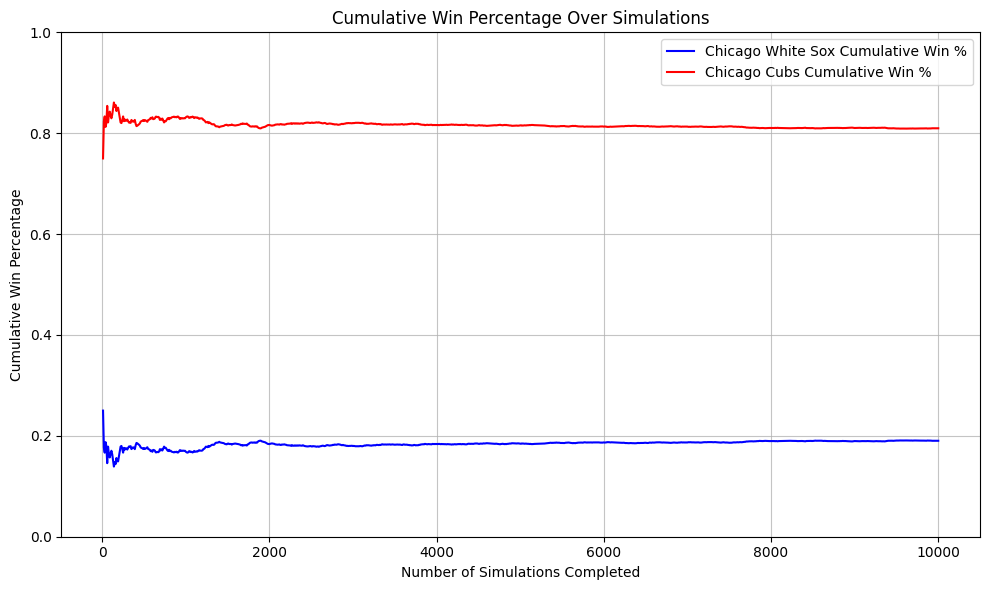

In [16]:
import random
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np # For histogram binning and other numerical operations

# Keep Player and Pitcher class definitions (simplified)
class Player:
    def __init__(self, name, avg, obp, slg):
        self.name = name
        try:
            self.hit_chance = float(avg)
            self.on_base_chance = float(obp)
            self.extra_base_chance = (float(slg) - float(avg)) / 3 if float(slg) > float(avg) else 0.05
            self.strikeout_chance = 0.20
            self.walk_chance = (float(obp) - float(avg)) if float(obp) > float(avg) else 0.08
        except ValueError:
            self.name = name + " (default_stats)"
            self.hit_chance = 0.250
            self.on_base_chance = 0.320
            self.extra_base_chance = 0.100
            self.strikeout_chance = 0.22
            self.walk_chance = 0.08

    def __str__(self):
        return self.name

class Pitcher:
    def __init__(self, name, era):
        self.name = name
        try:
            self.control_factor = (5.0 - min(float(era), 5.0)) / 5.0
            self.strikeout_bonus = (5.0 - min(float(era), 5.0)) * 0.02
        except ValueError:
            self.name = name + " (default_stats)"
            self.control_factor = 0.9
            self.strikeout_bonus = 0.01

    def __str__(self):
        return self.name

class GameState:
    def __init__(self):
        self.inning = 1
        self.top_of_inning = True
        self.outs = 0
        self.bases = [0, 0, 0]
        self.home_score = 0
        self.away_score = 0
        self.current_batter_index_home = 0
        self.current_batter_index_away = 0

    def record_out(self):
        self.outs += 1

    def advance_runners(self, hit_type):
        runs_scored_this_play = 0
        if hit_type == 4: # Home run
            runs_scored_this_play = sum(self.bases) + 1
            self.bases = [0, 0, 0]
        elif hit_type == 0: # Walk or HBP
            if self.bases[0] == 1 and self.bases[1] == 1 and self.bases[2] == 1:
                runs_scored_this_play += 1
            elif self.bases[0] == 1 and self.bases[1] == 1:
                self.bases[2] = 1
            elif self.bases[0] == 1:
                self.bases[1] = 1
            self.bases[0] = 1
        else: # Hit
            if self.bases[2] == 1:
                runs_scored_this_play += 1
                self.bases[2] = 0
            if self.bases[1] == 1:
                if hit_type >= 2:
                    runs_scored_this_play += 1
                    self.bases[1] = 0
                elif hit_type == 1:
                    self.bases[2] = 1
                    self.bases[1] = 0
            if self.bases[0] == 1:
                if hit_type >= 3:
                    runs_scored_this_play += 1
                    self.bases[0] = 0
                elif hit_type == 2:
                    self.bases[2] = 1
                    self.bases[0] = 0
                elif hit_type == 1:
                    self.bases[1] = 1
                    self.bases[0] = 0
            if hit_type > 0:
                self.bases[hit_type -1] = 1

        if self.top_of_inning:
            self.away_score += runs_scored_this_play
        else:
            self.home_score += runs_scored_this_play
        return runs_scored_this_play

    def new_inning_half(self):
        self.outs = 0
        self.bases = [0, 0, 0]
        if not self.top_of_inning:
            self.inning += 1
            self.top_of_inning = True
        else:
            self.top_of_inning = False

def simulate_at_bat_no_print(batter, pitcher, game_state):
    adj_hit_chance = batter.hit_chance * pitcher.control_factor
    adj_walk_chance = batter.walk_chance / (pitcher.control_factor if pitcher.control_factor > 0 else 1)
    adj_strikeout_chance = batter.strikeout_chance + pitcher.strikeout_bonus
    adj_hit_chance = max(0.01, min(adj_hit_chance, 0.9))
    adj_walk_chance = max(0.01, min(adj_walk_chance, 0.5))
    adj_strikeout_chance = max(0.05, min(adj_strikeout_chance, 0.7))
    total_prob_event = adj_hit_chance + adj_walk_chance + adj_strikeout_chance
    other_out_chance = max(0.05, 1.0 - total_prob_event)
    total_prob_normalized = adj_hit_chance + adj_walk_chance + adj_strikeout_chance + other_out_chance

    if total_prob_normalized == 0:
        adj_hit_chance = 0.1 / 0.4; adj_walk_chance = 0.05 / 0.4; adj_strikeout_chance = 0.2 / 0.4; other_out_chance = 0.05 /0.4
    else:
        adj_hit_chance /= total_prob_normalized; adj_walk_chance /= total_prob_normalized; adj_strikeout_chance /= total_prob_normalized; other_out_chance /= total_prob_normalized

    outcome_rand = random.random()
    if outcome_rand < adj_strikeout_chance: game_state.record_out()
    elif outcome_rand < adj_strikeout_chance + adj_walk_chance: game_state.advance_runners(0)
    elif outcome_rand < adj_strikeout_chance + adj_walk_chance + adj_hit_chance:
        hit_rand = random.random()
        if hit_rand < (batter.extra_base_chance / batter.hit_chance if batter.hit_chance > 0 else 0.05) * 0.2: game_state.advance_runners(4)
        elif hit_rand < (batter.extra_base_chance / batter.hit_chance if batter.hit_chance > 0 else 0.05) * 0.5: game_state.advance_runners(3)
        elif hit_rand < (batter.extra_base_chance / batter.hit_chance if batter.hit_chance > 0 else 0.05): game_state.advance_runners(2)
        else: game_state.advance_runners(1)
    else: game_state.record_out()

def simulate_inning_half_no_print(batting_team_lineup, pitching_team_pitcher, game_state, current_batter_index):
    if not batting_team_lineup: game_state.outs = 3; return current_batter_index
    batter_idx = current_batter_index
    while game_state.outs < 3:
        current_batter = batting_team_lineup[batter_idx % len(batting_team_lineup)]
        simulate_at_bat_no_print(current_batter, pitching_team_pitcher, game_state)
        batter_idx += 1
        if game_state.outs >= 3: break
    return batter_idx % len(batting_team_lineup)

def simulate_game_no_print(home_team_name, away_team_name, home_lineup, away_lineup, home_pitcher, away_pitcher, num_innings=9):
    game = GameState()
    if not home_lineup or not away_lineup or not home_pitcher or not away_pitcher: return -1, -1, home_team_name, away_team_name
    for _ in range(num_innings * 2): # Iterate enough times for potential extra innings, actual innings tracked by game.inning
        if game.inning > num_innings and game.home_score > game.away_score and game.top_of_inning: break # Home leads, top of inning > 9
        if game.inning > num_innings and game.away_score > game.home_score and not game.top_of_inning: break # Away leads, bottom of inning > 9, game over for home
        if game.inning > num_innings and game.home_score != game.away_score and game.outs ==3 and not game.top_of_inning : break # Game decided in extras bottom

        if game.top_of_inning:
            current_lineup = away_lineup
            current_pitcher = home_pitcher
            current_batter_index_ref = "current_batter_index_away"
        else: # Bottom of inning
            # Check for walk-off or end of regulation if home is leading
            if game.inning >= num_innings and game.home_score > game.away_score: break
            # If it's the bottom of the 9th or later and away team leads, home team must bat
            if game.inning >= num_innings and game.away_score > game.home_score and game.outs == 3: # Should be caught by next half-inning logic too
                 pass # allow home team to bat

            current_lineup = home_lineup
            current_pitcher = away_pitcher
            current_batter_index_ref = "current_batter_index_home"

        current_batter_index_val = getattr(game, current_batter_index_ref)
        next_batter_index = simulate_inning_half_no_print(current_lineup, current_pitcher, game, current_batter_index_val)
        setattr(game, current_batter_index_ref, next_batter_index)

        if game.outs == 3:
            # Check for game end conditions before starting new half
            if game.inning >= num_innings:
                if game.top_of_inning and game.home_score > game.away_score: # Home team was already leading going into bottom of 9th (or won in extras prev inning)
                    break
                if not game.top_of_inning and game.home_score != game.away_score : # Game decided
                    break
            game.new_inning_half()
            if game.inning > num_innings + 5 and game.home_score == game.away_score : # Safety break for very long ties (e.g. 15 innings)
                # print("Game ended in a tie after 15 innings for this simulation run.")
                break


    return game.home_score, game.away_score, home_team_name, away_team_name

def load_batting_data(filepath, num_players=9):
    try:
        df = pd.read_csv(filepath)
        df = df[~df['Player'].str.contains("Team Totals", na=False)]
        if len(df) == 0: return []
        while len(df) < num_players: df = pd.concat([df, df], ignore_index=True)
        batters = []
        for _, row in df.head(num_players).iterrows():
            try: avg = float(row['BA']); obp = float(row['OBP']); slg = float(row['SLG'])
            except ValueError: avg = 0.250; obp = 0.320; slg = 0.400
            batters.append(Player(row['Player'], avg, obp, slg))
        return batters
    except FileNotFoundError: print(f"Error: File not found {filepath}"); return []
    except KeyError as e: print(f"Error: CSV file {filepath} is missing column: {e}"); return []

def load_pitching_data(filepath):
    try:
        df = pd.read_csv(filepath)
        df = df[~df['Player'].str.contains("Team Totals", na=False)]
        if df.empty: return None
        pitcher_row = df.iloc[0]
        try: era = float(pitcher_row['ERA'])
        except ValueError: era = 4.00
        return Pitcher(pitcher_row['Player'], era)
    except FileNotFoundError: print(f"Error: File not found {filepath}"); return None
    except KeyError as e: print(f"Error: CSV file {filepath} is missing column: {e}"); return None

# --- Main Simulation ---
if __name__ == "__main__":
    num_simulations = 10000 # You can adjust this
    home_team_wins = 0
    away_team_wins = 0

    all_home_scores = []
    all_away_scores = []
    cumulative_home_wins_over_sims = []
    cumulative_away_wins_over_sims = []
    simulation_counts_for_plot = []

    # Define file paths to look in parent directory's prepared_data folder
    import os
    try:
        # Try to get the current working directory and go one level up
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        base_path = os.path.join(parent_dir, "prepared_data") + os.sep

        # Verify if prepared_data exists in parent directory
        if not os.path.exists(base_path):
            print(f"Warning: Could not find {base_path}. Falling back to current directory.")
            base_path = os.path.join(current_dir, "prepared_data") + os.sep
            
        print(f"Attempting to load data from: {base_path}")
    except Exception as e:
        print(f"Error determining file path: {e}")
        base_path = "prepared_data/" # Fallback to relative path
    
    cubs_batting_file = base_path + "cubs_standard_batting_clean.csv"
    cubs_pitching_file = base_path + "cubs_standard_pitching_clean.csv"
    sox_batting_file = base_path + "whitesox_standard_batting_clean.csv"
    sox_pitching_file = base_path + "whitesox_standard_pitching_clean.csv"

    # Check if files exist and print findings
    for file_path in [cubs_batting_file, cubs_pitching_file, sox_batting_file, sox_pitching_file]:
        if os.path.exists(file_path):
            print(f"Found: {file_path}")
        else:
            print(f"Missing: {file_path}")

    cubs_batters_roster = load_batting_data(cubs_batting_file)
    cubs_pitcher_staff = load_pitching_data(cubs_pitching_file)
    sox_batters_roster = load_batting_data(sox_batting_file)
    sox_pitcher_staff = load_pitching_data(sox_pitching_file)

    home_team_name_const = "Chicago White Sox"
    away_team_name_const = "Chicago Cubs"

    if not cubs_batters_roster or not sox_batters_roster or not cubs_pitcher_staff or not sox_pitcher_staff:
        print("FATAL: Data loading failed. Cannot run simulation. Please check file paths and CSV contents.")
        print(f"Looked for Cubs batting: {cubs_batting_file}")
        print(f"Looked for Sox batting: {sox_batting_file}")
        # exit() # Optional: stop script if data not loaded
    else:
        print(f"Running {num_simulations} simulations...")
        current_home_wins = 0
        current_away_wins = 0

        for i in range(num_simulations):
            if (i + 1) % (num_simulations // 20) == 0 : # Print progress more frequently for long sims
                print(f"Completed {i + 1}/{num_simulations} simulations...")

            current_cubs_lineup = cubs_batters_roster[:9]
            current_sox_lineup = sox_batters_roster[:9]
            current_cubs_pitcher = cubs_pitcher_staff
            current_sox_pitcher = sox_pitcher_staff

            home_s, away_s, _, _ = simulate_game_no_print(
                home_team_name=home_team_name_const,
                away_team_name=away_team_name_const,
                home_lineup=current_sox_lineup,
                away_lineup=current_cubs_lineup,
                home_pitcher=current_sox_pitcher,
                away_pitcher=current_cubs_pitcher
            )

            if home_s != -1: # Valid game
                all_home_scores.append(home_s)
                all_away_scores.append(away_s)

                if home_s > away_s:
                    current_home_wins += 1
                elif away_s > home_s:
                    current_away_wins += 1

                # For cumulative plot - record at intervals
                if (i + 1) % (num_simulations // 1000 if num_simulations >=1000 else 1) == 0 or i == num_simulations -1 : # Store data points for line chart
                    simulation_counts_for_plot.append(i + 1)
                    if (current_home_wins + current_away_wins) > 0:
                        cumulative_home_wins_over_sims.append(current_home_wins / (current_home_wins + current_away_wins))
                        cumulative_away_wins_over_sims.append(current_away_wins / (current_home_wins + current_away_wins))
                    else: # Avoid division by zero at the very start
                        cumulative_home_wins_over_sims.append(0)
                        cumulative_away_wins_over_sims.append(0)


        print("\n--- Simulation Results (Text) ---")
        total_valid_games = len(all_home_scores)
        if total_valid_games > 0:
            home_team_actual_wins = sum(1 for i in range(total_valid_games) if all_home_scores[i] > all_away_scores[i])
            away_team_actual_wins = sum(1 for i in range(total_valid_games) if all_away_scores[i] > all_home_scores[i])
            ties = total_valid_games - (home_team_actual_wins + away_team_actual_wins)

            print(f"Total valid simulations: {total_valid_games}")
            print(f"{home_team_name_const} Wins: {home_team_actual_wins} ({ (home_team_actual_wins/total_valid_games)*100:.2f}%)")
            print(f"{away_team_name_const} Wins: {away_team_actual_wins} ({ (away_team_actual_wins/total_valid_games)*100:.2f}%)")
            if ties > 0:
                print(f"Ties (after 9+ innings): {ties} ({(ties/total_valid_games)*100:.2f}%)")
        else:
            print("No valid games were simulated.")


        # --- Plotting ---
        if total_valid_games > 0:
            # 2. Combined Score Distribution Bar Chart
            max_score = max(max(all_home_scores, default=0), max(all_away_scores, default=0))
            # Define bins for the histogram explicitly from 0 to max_score
            bins = np.arange(0, max_score + 2) - 0.5 # Centering bins around integers

            plt.figure(figsize=(10, 6)) # Single figure for combined plot

            # Plotting home team scores
            plt.hist(all_home_scores, bins=bins, alpha=0.7, rwidth=0.85, label=f'{home_team_name_const} Scores', color='skyblue', edgecolor='black')
            # Plotting away team scores on the same axes
            plt.hist(all_away_scores, bins=bins, alpha=0.7, rwidth=0.85, label=f'{away_team_name_const} Scores', color='lightcoral', edgecolor='black')
            
            plt.title('Combined Score Distribution')
            plt.xlabel('Runs Scored')
            plt.ylabel('Frequency (Number of Games)')
            plt.xticks(np.arange(0, max_score + 1)) # Ensure integer ticks for scores
            plt.legend()
            plt.grid(axis='y', alpha=0.75)
            plt.tight_layout()
            plt.savefig("combined_score_distribution.png")
            print("\nCombined score distribution plot saved as combined_score_distribution.png")
            # plt.show()

            # 3. Cumulative Win Percentage Line Chart
            if simulation_counts_for_plot: # Check if data was collected
                plt.figure(figsize=(10, 6))
                plt.plot(simulation_counts_for_plot, cumulative_home_wins_over_sims, label=f'{home_team_name_const} Cumulative Win %', color='blue')
                plt.plot(simulation_counts_for_plot, cumulative_away_wins_over_sims, label=f'{away_team_name_const} Cumulative Win %', color='red')
                plt.title('Cumulative Win Percentage Over Simulations')
                plt.xlabel('Number of Simulations Completed')
                plt.ylabel('Cumulative Win Percentage')
                plt.ylim(0, 1) # Win percentage is between 0 and 1
                plt.grid(True, alpha=0.75)
                plt.legend()
                plt.tight_layout()
                plt.savefig("cumulative_win_percentage.png") # Save the plot
                print("Cumulative win percentage plot saved as cumulative_win_percentage.png")
                # plt.show() # Uncomment to display plots
            else:
                print("Not enough data points to plot cumulative win percentages (check simulation count and recording interval).")

        else:
            print("No data to plot as no valid games were simulated.")